## **Image Denoising Using UNET**


# Loading Useful packages

In [1]:
# import os
# os.environ["XLA_FLAGS"] = "--xla_gpu_cuda_data_dir=/usr/local/cuda-<CUDA_VERSION>"


In [2]:
# from tensorflow.keras.backend import clear_session
# clear_session()

# import tensorflow as tf
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# # import os
# # os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# gpus = tf.config.list_physical_devices('GPU')
# for gpu in gpus:
#     tf.config.experimental.set_memory_growth(gpu, True)



In [3]:
## Load useful packages
!pip install wget
!pip install h5py
!pip install scikit-learn
!pip install tensorflow[and-cuda]
!pip install scikit-image

import wget
from os import path
import h5py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


2024-10-31 21:49:49.448926: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-31 21:49:49.460994: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1730400589.474302 4112329 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1730400589.478246 4112329 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-31 21:49:49.492023: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

# Pre-processing wheather-classification dataset

**Loading and processing dataset**

In [4]:
classes = ('cloudy','rain','shine','sunrise')
data_path = 'https://raw.githubusercontent.com/Shujaat123/Weather_Classification/master/dataset/'

flist = []
for fname in classes:
  filename = 'WeatherClassificationDB_'+fname+'.mat'
  if(path.exists(filename)):
    # !rm $filename
    # print('existing file:', filename, ' has been deleted')
    print(filename, ' already exist.')
    file_path = data_path + filename
  else:
    print('downloading latest version of file:', filename)
    file_path = data_path + filename
    wget.download(file_path, filename)
  print('DONE')
  flist.append(filename)



WeatherClassificationDB_cloudy.mat  already exist.
DONE
WeatherClassificationDB_rain.mat  already exist.
DONE
WeatherClassificationDB_shine.mat  already exist.
DONE
WeatherClassificationDB_sunrise.mat  already exist.
DONE


In [5]:
cloudy_imgs = h5py.File(flist[0], 'r')['images']['input']
rain_imgs = h5py.File(flist[1], 'r')['images']['input']
shine_imgs = h5py.File(flist[2], 'r')['images']['input']
sunrise_imgs = h5py.File(flist[3], 'r')['images']['input']

print(cloudy_imgs.shape) # (NHWC)
print(rain_imgs.shape) # (NHWC)
print(shine_imgs.shape) # (NHWC)
print(sunrise_imgs.shape) # (NHWC)

InputImages = np.concatenate((cloudy_imgs,rain_imgs,shine_imgs,sunrise_imgs), axis = 0)
InputImages = np.array(InputImages)/255

InputImages.shape


(207, 256, 256, 3)
(215, 256, 256, 3)
(253, 256, 256, 3)
(357, 256, 256, 3)


(1032, 256, 256, 3)

3. Add Gaussian Noise to the Dataset


In [6]:
def add_gaussian_noise(images, mean=0, stddev=0.1):
    noise = np.random.normal(mean, stddev, images.shape)
    noisy_images = images + noise
    noisy_images = np.clip(noisy_images, 0., 1.)  # Clip values to be in range [0, 1]
    return noisy_images


4. Split Dataset into Train, Validation, and Test Sets


In [7]:
# Assuming `cloudy_imgs` is your dataset
noisy_imgs = add_gaussian_noise(InputImages)

# Split the dataset: 70% for training, 10% for validation, 20% for testing
X_train, X_temp, Y_train, Y_temp = train_test_split(noisy_imgs, InputImages, test_size=0.3, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.666, random_state=42)

print("Train set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape:", X_test.shape)


Train set shape: (722, 256, 256, 3)
Validation set shape: (103, 256, 256, 3)
Test set shape: (207, 256, 256, 3)


5. Define the UNet Model


In [8]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, BatchNormalization

def unet_model(input_size=(256, 256, 3), Nc=64):
    inputs = Input(input_size)

    # Contracting Path
    conv1 = Conv2D(Nc, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(Nc, 3, activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)


    conv2 = Conv2D(Nc * 2, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(Nc * 2, 3, activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(Nc * 4, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(Nc * 4, 3, activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(Nc * 8, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(Nc * 8, 3, activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(Nc * 16, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(Nc * 16, 3, activation='relu', padding='same')(conv5)

    # Expanding Path
    up6 = Conv2DTranspose(Nc * 8, 2, strides=(2, 2), padding='same')(conv5)
    merge6 = concatenate([conv4, up6], axis=3)
    conv6 = Conv2D(Nc * 8, 3, activation='relu', padding='same')(merge6)
    conv6 = Conv2D(Nc * 8, 3, activation='relu', padding='same')(conv6)

    up7 = Conv2DTranspose(Nc * 4, 2, strides=(2, 2), padding='same')(conv6)
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(Nc * 4, 3, activation='relu', padding='same')(merge7)
    conv7 = Conv2D(Nc * 4, 3, activation='relu', padding='same')(conv7)

    up8 = Conv2DTranspose(Nc * 2, 2, strides=(2, 2), padding='same')(conv7)
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(Nc * 2, 3, activation='relu', padding='same')(merge8)
    conv8 = Conv2D(Nc * 2, 3, activation='relu', padding='same')(conv8)

    up9 = Conv2DTranspose(Nc, 2, strides=(2, 2), padding='same')(conv8)
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(Nc, 3, activation='relu', padding='same')(merge9)
    conv9 = Conv2D(Nc, 3, activation='relu', padding='same')(conv9)

    conv10 = Conv2D(3, 1, activation='tanh')(conv9)  # Output layer, keeping 3 channels for RGB
    merge10 = concatenate([inputs, conv10], axis=3)
    conv10 = Conv2D(3, 1, activation='sigmoid')(merge10)  # Output layer, keeping 3 channels for RGB
    model = Model(inputs=inputs, outputs=conv10)
    return model


6. Compile the Model


In [9]:
import tensorflow as tf
from skimage.metrics import structural_similarity as ssim

# PSNR Metric using TensorFlow
def psnr_metric(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=1.0)

# SSIM Metric using TensorFlow
def ssim_metric(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)  # Cast ground truth to float32
    y_pred = tf.cast(y_pred, tf.float32)  # Cast predictions to float32
    return tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))


    return tf.py_function(compute_ssim, [y_true, y_pred], tf.float32)

model = unet_model(input_size=(256, 256, 3), Nc=32)  # (256, 256 image size)
model.compile(optimizer=Adam(learning_rate=1e-3),
              loss='mae',
              metrics=[psnr_metric, ssim_metric])

model.summary()


I0000 00:00:1730400598.300728 4112329 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 18447 MB memory:  -> device: 0, name: NVIDIA RTX A4500, pci bus id: 0000:67:00.0, compute capability: 8.6
I0000 00:00:1730400598.301164 4112329 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 18424 MB memory:  -> device: 1, name: NVIDIA RTX A4500, pci bus id: 0000:68:00.0, compute capability: 8.6


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      9,248 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │    590,080 │ conv2d_6[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      1,024 │ conv2d_7[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ batch_normalizat

 Total params: 7,762,104 (29.61 MB)

 Trainable params: 7,761,144 (29.61 MB)

 Non-trainable params: 960 (3.75 KB)

7. Train the Model


In [10]:
print(f"X_train shape: {X_train.shape}")
print(f"Y_train shape: {Y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"Y_val shape: {Y_val.shape}")


X_train shape: (722, 256, 256, 3)
Y_train shape: (722, 256, 256, 3)
X_val shape: (103, 256, 256, 3)
Y_val shape: (103, 256, 256, 3)


In [11]:
checkpoint = ModelCheckpoint('unet_denoising.keras', monitor='val_loss', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=200, batch_size=16, callbacks=[checkpoint, early_stopping])


Epoch 1/200


I0000 00:00:1730400605.449632 4112456 service.cc:148] XLA service 0x702afc016230 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730400605.449659 4112456 service.cc:156]   StreamExecutor device (0): NVIDIA RTX A4500, Compute Capability 8.6
I0000 00:00:1730400605.449662 4112456 service.cc:156]   StreamExecutor device (1): NVIDIA RTX A4500, Compute Capability 8.6
2024-10-31 21:50:05.591606: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
W0000 00:00:1730400605.855717 4112456 assert_op.cc:38] Ignoring Assert operator PSNR/Assert/Assert
W0000 00:00:1730400605.856534 4112456 assert_op.cc:38] Ignoring Assert operator PSNR/Assert_1/Assert
W0000 00:00:1730400605.857731 4112456 assert_op.cc:38] Ignoring Assert operator SSIM/Assert/Assert
W0000 00:00:1730400605.858166 4112456 assert_op.cc:38] Ignoring Assert operator SSIM/Assert_1/Asser

 1/46 ━━━━━━━━━━━━━━━━━━━━ 14:52 20s/step - loss: 0.2270 - psnr_metric: 11.9656 - ssim_metric: 0.3619

I0000 00:00:1730400620.474034 4112456 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 0.1717 - psnr_metric: 14.3291 - ssim_metric: 0.4484

W0000 00:00:1730400625.318916 4112456 assert_op.cc:38] Ignoring Assert operator PSNR/Assert/Assert
W0000 00:00:1730400625.319057 4112456 assert_op.cc:38] Ignoring Assert operator PSNR/Assert_1/Assert
W0000 00:00:1730400625.319371 4112456 assert_op.cc:38] Ignoring Assert operator SSIM/Assert/Assert
W0000 00:00:1730400625.319482 4112456 assert_op.cc:38] Ignoring Assert operator SSIM/Assert_1/Assert
W0000 00:00:1730400625.319616 4112456 assert_op.cc:38] Ignoring Assert operator SSIM/Assert_2/Assert
W0000 00:00:1730400625.319698 4112456 assert_op.cc:38] Ignoring Assert operator SSIM/Assert_3/Assert


46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - loss: 0.1713 - psnr_metric: 14.3494 - ssim_metric: 0.4495

W0000 00:00:1730400632.297725 4112455 assert_op.cc:38] Ignoring Assert operator PSNR/Assert/Assert
W0000 00:00:1730400632.298677 4112455 assert_op.cc:38] Ignoring Assert operator PSNR/Assert_1/Assert
W0000 00:00:1730400632.299916 4112455 assert_op.cc:38] Ignoring Assert operator SSIM/Assert/Assert
W0000 00:00:1730400632.300375 4112455 assert_op.cc:38] Ignoring Assert operator SSIM/Assert_1/Assert
W0000 00:00:1730400632.300903 4112455 assert_op.cc:38] Ignoring Assert operator SSIM/Assert_2/Assert
W0000 00:00:1730400632.301252 4112455 assert_op.cc:38] Ignoring Assert operator SSIM/Assert_3/Assert
W0000 00:00:1730400635.147982 4112456 assert_op.cc:38] Ignoring Assert operator PSNR/Assert/Assert
W0000 00:00:1730400635.148127 4112456 assert_op.cc:38] Ignoring Assert operator PSNR/Assert_1/Assert



Epoch 1: val_loss improved from inf to 0.18413, saving model to unet_denoising.keras
46/46 ━━━━━━━━━━━━━━━━━━━━ 37s 378ms/step - loss: 0.1709 - psnr_metric: 14.3688 - ssim_metric: 0.4504 - val_loss: 0.1841 - val_psnr_metric: 13.6548 - val_ssim_metric: 0.5256
Epoch 2/200
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 0.1251 - psnr_metric: 16.8364 - ssim_metric: 0.5532
Epoch 2: val_loss improved from 0.18413 to 0.15889, saving model to unet_denoising.keras
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - loss: 0.1251 - psnr_metric: 16.8372 - ssim_metric: 0.5535 - val_loss: 0.1589 - val_psnr_metric: 14.9730 - val_ssim_metric: 0.5528
Epoch 3/200
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 0.1146 - psnr_metric: 17.7807 - ssim_metric: 0.5759
Epoch 3: val_loss improved from 0.15889 to 0.14522, saving model to unet_denoising.keras
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - loss: 0.1144 - psnr_metric: 17.7900 - ssim_metric: 0.5763 - val_loss: 0.1452 - val_psnr_metric: 15.8764 - val_ssim_metri

8. Evaluate the Model on the Test Set


In [12]:
# Evaluate on test set
test_loss, test_psnr, test_ssim = model.evaluate(X_test, Y_test)
print(f"Test Loss: {test_loss}")
print(f"Test PSNR: {test_psnr}")
print(f"Test SSIM: {test_ssim}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 649ms/step - loss: 0.0369 - psnr_metric: 26.8000 - ssim_metric: 0.7637
Test Loss: 0.03728571906685829
Test PSNR: 26.759483337402344
Test SSIM: 0.7671787142753601


9. Performance Metrics (PSNR and SSIM)


In [13]:
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import numpy as np

# Ensure images are in float32 and normalize to [0, 1]
def normalize_and_cast(image):
    image = image.astype('float32')
    return np.clip(image, 0, 1)

def calculate_metrics(original, denoised):
    # Normalize and cast both original and denoised images
    original = normalize_and_cast(original)
    denoised = normalize_and_cast(denoised)

    psnr_val = psnr(original, denoised, data_range=1.0)  # Specify data range
    ssim_val = ssim(original, denoised, data_range=1.0, multichannel=True, win_size=3)  # Specify window size

    return psnr_val, ssim_val

# Get predictions on test set
predictions = model.predict(X_test)

psnr_values = []
ssim_values = []

for i in range(len(X_test)):
    p, s = calculate_metrics(Y_test[i], predictions[i])
    psnr_values.append(p)
    ssim_values.append(s)

print(f"Average PSNR: {np.mean(psnr_values)}, Average SSIM: {np.mean(ssim_values)}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step
Average PSNR: 26.759483707017203, Average SSIM: 0.819155603893124


10. Visualize Results


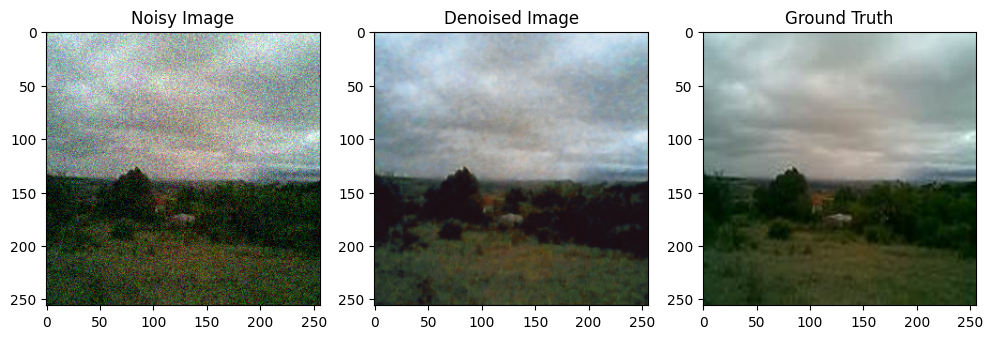

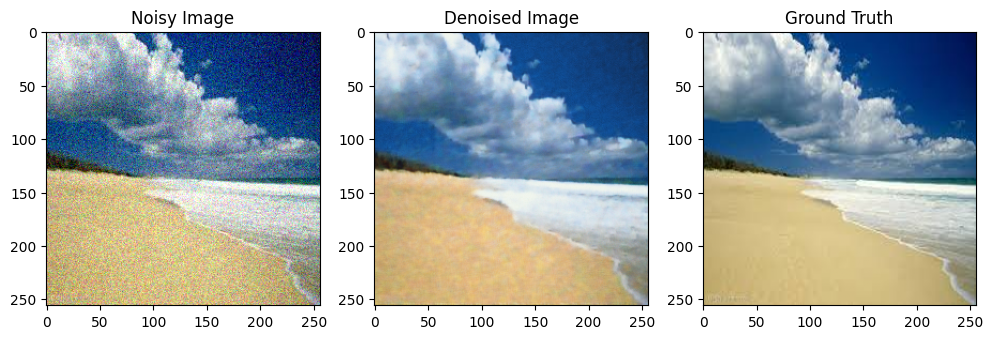

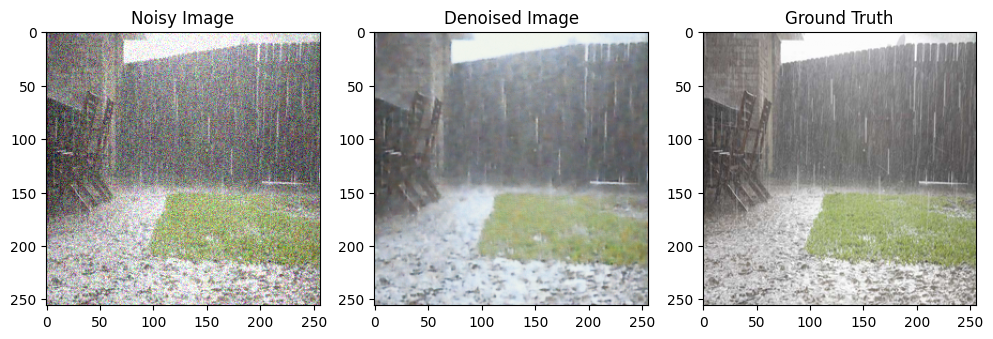

In [14]:
def display_images(noisy, denoised, ground_truth, idx):
    plt.figure(figsize=(12, 4))

    # Display Noisy Image
    plt.subplot(1, 3, 1)
    plt.imshow(noisy[idx])
    plt.title("Noisy Image")

    # Display Denoised Image
    plt.subplot(1, 3, 2)
    plt.imshow(denoised[idx])
    plt.title("Denoised Image")

    # Display Ground Truth
    plt.subplot(1, 3, 3)
    plt.imshow(ground_truth[idx])
    plt.title("Ground Truth")

    plt.show()

# Display a few test examples
for i in range(3):
    display_images(X_test, predictions, Y_test, i)
